In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import spatial

In [2]:
mut = pd.read_csv('../data/MutSpecVertebratescytb.csv')
mut.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [27]:
canc_df = pd.read_csv('../data/external/cancer_mutspec.csv')
canc_df = canc_df[['Mut','MutSpec_ExDloop']]
canc_df = canc_df.rename(columns={"MutSpec_ExDloop":"MutSpec"})
canc_df['Class'] = 'ex_dloop'
canc_df['MutBase'] = canc_df.Mut.str.slice(2, 5)
canc_df.head()

,Mut,MutSpec,Class,MutBase
0,A[A>C]A,0.000000,ex_dloop,A>C
1,A[A>C]C,0.000783,ex_dloop,A>C
2,A[A>C]G,0.000000,ex_dloop,A>C
3,A[A>C]T,0.000084,ex_dloop,A>C
4,A[A>G]A,0.008273,ex_dloop,A>G


In [4]:
cl_vec = list(mut['Class'].drop_duplicates()) + ['cancer']

In [5]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    
    return ms_cls

In [37]:
def get_similarity_table(mut_df: pd.DataFrame, canc_df: pd.DataFrame, mut_type='all', n_iter=100):
    TS_vec = ['A>G', 'G>A', 'T>C', 'C>T']
    TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']

    n = 0
    to_heatmap = []

    if mut_type == 'TS':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TS_vec)]
        canc_df = canc_df[canc_df['MutBase'].isin(TS_vec)]
    elif mut_type == 'TV':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TV_vec)]
        canc_df = canc_df[canc_df['MutBase'].isin(TV_vec)]
    elif mut_type =='all':
        mut_to_cos = mut_df.copy()
    else:
        raise('Error, try another MutType')
    while n < n_iter:
        for cls1 in cl_vec:
            if cls1 != 'cancer':
                df1_sps = mut_to_cos[mut_to_cos['Class'] == cls1]['Species'].sample(n=20, replace=False)
                df1 = calc_mutspec_class(mut_to_cos[mut_to_cos['Species'].isin(df1_sps)])
            else:
                df1 = canc_df
            for cls2 in cl_vec:
                if cls1 == cls2:
                    cos192=0
                elif cls2 != 'cancer':
                    df2_sps = mut_to_cos[mut_to_cos['Class'] == cls2]['Species'].sample(n=20, replace=False)
                    df2 = calc_mutspec_class(mut_to_cos[mut_to_cos['Species'].isin(df2_sps)])
                    cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
                else:
                    df2 = canc_df
                    cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
                    
                cos_res = {'Class1':cls1, 'Class2':cls2, 'Similarity':1-cos192}
                to_heatmap.append(cos_res)
        n += 1

    return pd.DataFrame(to_heatmap)

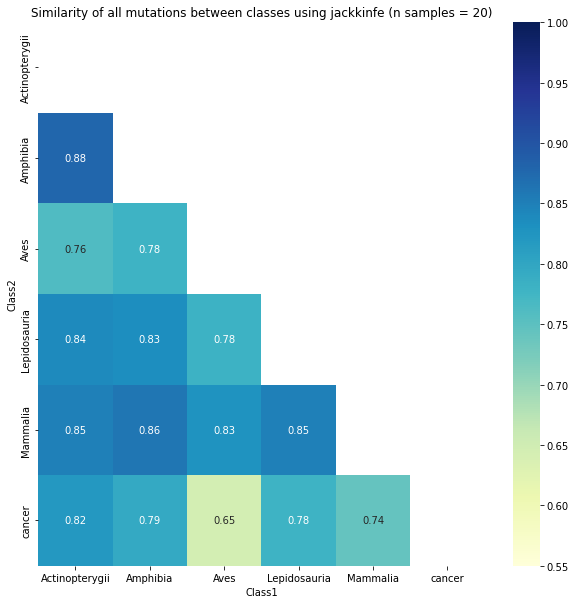

In [38]:
to_heatmap = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='all')
all_heatmap = to_heatmap.groupby(['Class1', 'Class2']).median().reset_index().pivot('Class2', 'Class1', 'Similarity')
#all_heatmap.index = pd.CategoricalIndex(all_heatmap.index, categories= ["Actinopterygii",
#                                        "Amphibia", "Lepidosauria", "Mammalia", "Aves", "cancer"])
#all_heatmap.sort_index(axis=0, inplace=True)
matrix = np.triu(all_heatmap)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(all_heatmap, annot=True, mask=matrix, cmap="YlGnBu", vmin =0.55, vmax=1)
ax.set_title('Similarity of all mutations between classes using jackkinfe (n samples = 20)')
plt.savefig('../pictures/Jackknife_Similarity.pdf', dpi=300)

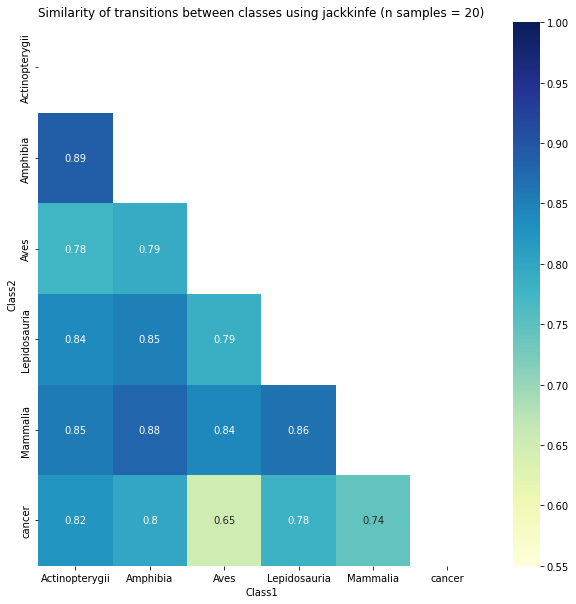

In [39]:
to_heatmap = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TS')
TS_heatmap = to_heatmap.groupby(['Class1', 'Class2']).median().reset_index().pivot('Class2', 'Class1', 'Similarity')
#TS_heatmap.index = pd.CategoricalIndex(TS_heatmap.index, categories= ["Actinopterygii",
#                                        "Amphibia", "Lepidosauria", "Mammalia", "Aves", "cancer"])
#TS_heatmap.sort_index(level=0, inplace=True)
TS_matrix = np.triu(TS_heatmap)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(TS_heatmap, annot=True, mask=TS_matrix, cmap="YlGnBu", vmin =0.55, vmax=1)
ax.set_title('Similarity of transitions between classes using jackkinfe (n samples = 20)')
plt.savefig('../pictures/Jackknife_SimilarityTS.pdf', dpi=300)

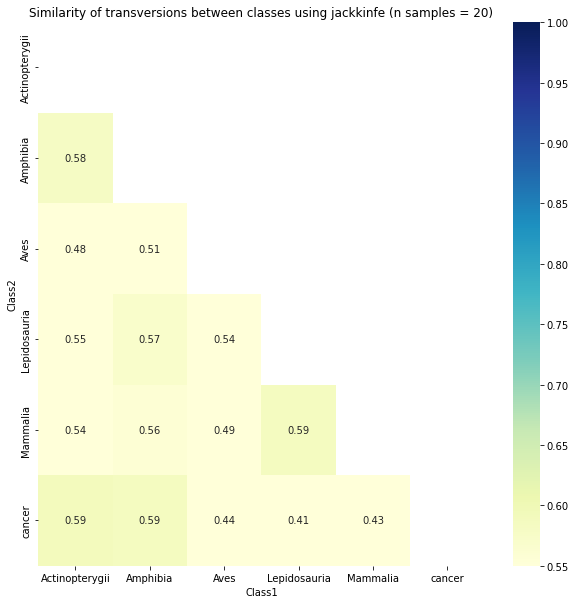

In [40]:
to_heatmap = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TV')
TV_heatmap = to_heatmap.groupby(['Class1', 'Class2']).median().reset_index().pivot('Class2', 'Class1', 'Similarity')
#TS_heatmap.index = pd.CategoricalIndex(TS_heatmap.index, categories= ["Actinopterygii",
#                                        "Amphibia", "Lepidosauria", "Mammalia", "Aves", "cancer"])
#TS_heatmap.sort_index(level=0, inplace=True)
TV_matrix = np.triu(TV_heatmap)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(TV_heatmap, annot=True, mask=TV_matrix, cmap="YlGnBu", vmin =0.55, vmax=1)
ax.set_title('Similarity of transversions between classes using jackkinfe (n samples = 20)')
plt.savefig('../pictures/Jackknife_SimilarityTV.pdf', dpi=300)